<a href="https://colab.research.google.com/github/dhiyauzh/Sentiment-Analysis-about-Trump-VS-Biden-for-US-Presidential-Election-2020-in-Twitter/blob/main/Konsultan_Politik_13%2C_20%2C_53.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Perkembangan teknologi telah mengubah cara masyarakat dalam berpendapat. Media sosial seperti Twitter telah menjadi tempat yang sering digunakan masyarakat dalam mengekspresikan diri mereka dalam kehidupan sehari-hari tak terkecuali urusan politik. Media sosial dapat menjadi tempat yang tepat bagi para politikus untuk dapat menjaring aspirasi, berkampanye, hingga menggiring opini. Kami memposisikan diri sebagai konsultan politik yang ingin melihat bagaimana ekspresi publik lewat media sosial dapat menggambarkan besarnya dukungan masyarakat terhadap suatu calon.
Kelompok kami akan menggunakan sebuah dataset yang berisi tweet mengenai pemilihan presiden Amerika Serikat pada 2020 lalu. Dari dataset ini kami akan menggunakan metode analisis LSTM untuk melihat sentimen opini user Twitter terhadap masing-masing calon. Dari analisis ini pula kami ingin melihat berapa besar dukungan lewat sentimen positif salah satu calon selaras dengan kemenangan calon tersebut pada Pemilu Amerika Serikat 2020.

dataset : https://www.kaggle.com/manchunhui/us-election-2020-tweets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from textblob import TextBlob
from wordcloud import wordcloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
nltk.download('wordnet')
pd.set_option('max_colwidth', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Input Data

In [ ]:
trump = pd.read_csv('../content/drive/MyDrive/Tugas Kuliah/AIML/hashtag_donaldtrump.csv' , lineterminator='\n')
biden = pd.read_csv('../content/drive/MyDrive/Tugas Kuliah/AIML/hashtag_joebiden.csv',  lineterminator='\n')

In [ ]:
trump.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: coprono Biden #donaldtrump https://t.co/6ceURhe1VP https://t.co/94jidLjoON",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he is VERY busy. Tremendously busy.,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we be worried?",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,covering Capitol Hill &DC politics in Arabic for 15+yrs. Mom of identical twins. Beach, chocolate & gym lover.",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [ ]:
biden.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.316529e+18,#HunterBiden #HunterBidenEmails #JoeBiden #JoeBidenMustStepDown https://t.co/9enmxWvePm,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family and my country. I will fight til my last breath for my children and grand children's freedoms. Trump2020",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.316529e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch This is how #Biden made his ! #TrumpIsNotAmerica !\nhttps://t.co/uBqAFU86Ip,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.316529e+18,@chrislongview Watching and setting dvr. Let’s give him bonus ratings!! #JoeBiden,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,2017-01-25 14:16:17,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529e+18,#censorship #HunterBiden #Biden #BidenEmails #BidenEmail #Corruption https://t.co/C6clrtshQl,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,"A Silicon Valley #independent #News #Media #Startup\n *If you have any tips you'd like us to cover, please DM or tag us*",2018-08-24 01:49:01,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [ ]:
print(trump.shape)
print(biden.shape)

(970919, 21)
(776886, 21)


Menggabung 2 tabel Trump dan Biden menjadi satu tabel

In [ ]:
trump['Candidate']= 'Trump'
biden['Candidate']= 'biden'
data_mixed = pd.concat([trump,biden])
data_mixed.sort_values(by='created_at')
data_mixed.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,Candidate
0,2020-10-15 00:00:01,1.316529e+18,#Elecciones2020 | En #Florida: #JoeBiden dice que #DonaldTrump solo se preocupa por él mismo. El demócrata fue anfitrión de encuentros de electores en #PembrokePines y #Miramar. Clic AQUÍ ⬇️⬇️⬇️\n⠀\n🌐https://t.co/qhIWpIUXsT\n_\n#ElSolLatino #yobrilloconelsol https://t.co/6FlCBWf1Mi,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.316529e+18,"Usa 2020, Trump contro Facebook e Twitter: coprono Biden #donaldtrump https://t.co/6ceURhe1VP https://t.co/94jidLjoON",26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,"#Trump: As a student I used to hear for years, for ten years, I heard China! In 2019! And we have 1.5 and they don't know how many we have and I asked them how many do we have and they said 'sir we don't know.' But we have millions. Like 300 million.\n\nUm. What?",2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,2 hours since last tweet from #Trump! Maybe he is VERY busy. Tremendously busy.,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we be worried?",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
4,2020-10-15 00:00:08,1.316529e+18,You get a tie! And you get a tie! #Trump ‘s rally #Iowa https://t.co/jJalUUmh5D,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,covering Capitol Hill &DC politics in Arabic for 15+yrs. Mom of identical twins. Beach, chocolate & gym lover.",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump


# Persiapan dan Pembersihan Data

In [ ]:
# Case Folding
data_mixed['tweet'] = data_mixed['tweet'].str.lower()

print('Case Folding Result : \n')
print(data_mixed['tweet'].head(5))
print('\n\n\n')

Case Folding Result : 

0                                                                                                                              en dice que solo se preocupa por  mismo el demcrata fue anfitrin de encuentros de electores en  clic aqu
1                                                                                                                                                                                      usa trump contro facebook  twitter coprono biden
2    as  student  used to hear for years for ten years  heard china in and we have and they do not know how many we have and  asked them how many do we have and they said sir we do not know but we have millions like million um what
3                                                                                                                                                                   hours since last tweet from maybe he is very busy tremendously busy
4                                               

In [ ]:
def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")
                
data_mixed['tweet'] = data_mixed['tweet'].apply(remove_tweet_special)

print('Remove Tweet Special Result : \n')
print(data_mixed['tweet'].head(5))
print('\n\n\n')

Remove Tweet Special Result : 

0                                                                                                                            en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu
1                                                                                                                                                                                   usa trump contro facebook twitter coprono biden
2    as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what
3                                                                                                                                                               hours since last tweet from maybe he is very busy tremendously busy
4                                                       

In [ ]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

data_mixed['tweet'] = data_mixed['tweet'].apply(remove_number)

print('Remove Number Result : \n')
print(data_mixed['tweet'].head(5))
print('\n\n\n')

Remove Number Result : 

0                                                                                                                            en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu
1                                                                                                                                                                                   usa trump contro facebook twitter coprono biden
2    as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what
3                                                                                                                                                               hours since last tweet from maybe he is very busy tremendously busy
4                                                              

In [ ]:
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

data_mixed['tweet'] = data_mixed['tweet'].apply(remove_punctuation)

print('Remove Punctuation Result : \n')
print(data_mixed['tweet'].head(5))
print('\n\n\n')

Remove Punctuation Result : 

0                                                                                                                            en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu
1                                                                                                                                                                                   usa trump contro facebook twitter coprono biden
2    as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what
3                                                                                                                                                               hours since last tweet from maybe he is very busy tremendously busy
4                                                         

In [ ]:
#remove whitespace leading trailing & multiple whitespace
def remove_whitespace(text):
    txt = text.strip()
    return re.sub('\s+',' ',txt)

data_mixed['tweet'] = data_mixed['tweet'].apply(remove_whitespace)

print('Remove Whitespace Result : \n')
print(data_mixed['tweet'].head(5))
print('\n\n\n')

Remove Whitespace Result : 

0                                                                                                                            en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu
1                                                                                                                                                                                   usa trump contro facebook twitter coprono biden
2    as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what
3                                                                                                                                                               hours since last tweet from maybe he is very busy tremendously busy
4                                                          

In [ ]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"dont": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

def cont_to_exp(x):
     if type(x) is str:
        x = x.replace('\\', '')
        for key in contractions:
            value = contractions[key]
            x = x.replace(key, value)
        return x
     else:
        return x

In [ ]:
data_mixed['tweet'] = data_mixed['tweet'].apply(lambda x: cont_to_exp(x))
data_mixed.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,Candidate
0,2020-10-15 00:00:01,1.316529e+18,en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,US,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.316529e+18,usa trump contro facebook twitter coprono biden,26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what,2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,US,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,hours since last tweet from maybe he is very busy tremendously busy,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we be worried?",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
4,2020-10-15 00:00:08,1.316529e+18,you get tie and you get tie rally,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,covering Capitol Hill &DC politics in Arabic for 15+yrs. Mom of identical twins. Beach, chocolate & gym lover.",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,US,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump


# Eksplorasi Data

In [ ]:
trump_clean = data_mixed[data_mixed['Candidate'] == 'Trump']
trump_clean.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,Candidate
0,2020-10-15 00:00:01,1.316529e+18,en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,Trump
1,2020-10-15 00:00:01,1.316529e+18,usa trump contro facebook twitter coprono biden,26.0,9.0,Social Mediaset,3.316176e+08,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie sul sito https://t.co/sC5iMbymSN e sul canale 51 del digitale terrestre,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530,Trump
2,2020-10-15 00:00:02,1.316529e+18,as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what,2.0,1.0,Twitter Web App,8.436472e+06,snarke,snarke,"Will mock for food! Freelance writer, blogger, commentator. Civics nerd. She/Her",2007-08-26 05:56:11,1185.0,Portland,45.520247,-122.674195,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060,Trump
3,2020-10-15 00:00:02,1.316529e+18,hours since last tweet from maybe he is very busy tremendously busy,0.0,0.0,Trumpytweeter,8.283556e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we be worried?",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591,Trump
4,2020-10-15 00:00:08,1.316529e+18,you get tie and you get tie rally,4.0,3.0,Twitter for iPhone,4.741380e+07,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,covering Capitol Hill &DC politics in Arabic for 15+yrs. Mom of identical twins. Beach, chocolate & gym lover.",2009-06-15 19:05:35,5393.0,Washington DC,38.894992,-77.036558,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121,Trump


In [ ]:
biden_clean = data_mixed[data_mixed['Candidate'] == 'biden']
biden_clean.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at,Candidate
0,2020-10-15 00:00:01,1.316529e+18,en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu,0.0,0.0,TweetDeck,3.606665e+08,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa este de #EEUU\n⠀⏹️ Facebook e Instagram\n⠀🏙️ Philadelphia: /elsollatinonewspaper\n⠀🌅 Miami: /elsollatinonewsmiami,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.774270,-80.193660,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00,biden
1,2020-10-15 00:00:18,1.316529e+18,,0.0,0.0,Twitter for iPad,8.099044e+08,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family and my country. I will fight til my last breath for my children and grand children's freedoms. Trump2020",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283,biden
2,2020-10-15 00:00:20,1.316529e+18,this is how made his,0.0,0.0,Twitter Web App,3.494182e+09,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.304036,-109.171431,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566,biden
3,2020-10-15 00:00:21,1.316529e+18,watching and setting dvr lets give him bonus ratings,0.0,0.0,Twitter for iPhone,8.242596e+17,Michelle Ferg,MichelleFerg4,NaN,2017-01-25 14:16:17,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849,biden
4,2020-10-15 00:00:22,1.316529e+18,,1.0,0.0,Twitter Web App,1.032807e+18,the Gold State,theegoldstate,"A Silicon Valley #independent #News #Media #Startup\n *If you have any tips you'd like us to cover, please DM or tag us*",2018-08-24 01:49:01,390.0,"California, USA",36.701463,-118.755997,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132,biden


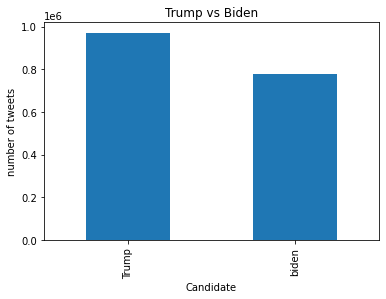

In [ ]:
# Perbandingan jumlah tweet
data_mixed.groupby('Candidate')['tweet'].count().plot.bar()
plt.ylabel('number of tweets')
plt.title('Trump vs Biden')
plt.show()

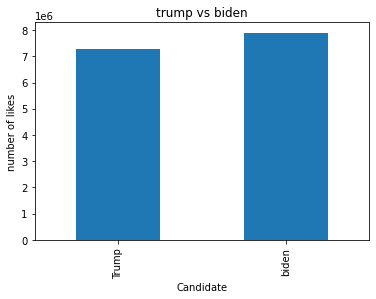

In [ ]:
# Perbandingan jumlah like

data_mixed.groupby('Candidate')['likes'].sum().plot.bar()
plt.ylabel('number of likes')
plt.title('trump vs biden')
plt.show()

In [ ]:
data_mixed.country.value_counts()

United States of America    332495
United States                61905
United Kingdom               58051
India                        40091
Germany                      35379
                             ...  
Tonga                            2
Saint Lucia                      1
Lesotho                          1
Northern Mariana Islands         1
East Timor                       1
Name: country, Length: 189, dtype: int64

In [ ]:
data_mixed['country']= data_mixed['country'].replace({"United States of America":"US","United States":"US"})
data_mixed.country.value_counts()

US                          394400
United Kingdom               58051
India                        40091
Germany                      35379
France                       35299
                             ...  
Samoa                            2
Northern Mariana Islands         1
Lesotho                          1
Saint Lucia                      1
East Timor                       1
Name: country, Length: 188, dtype: int64

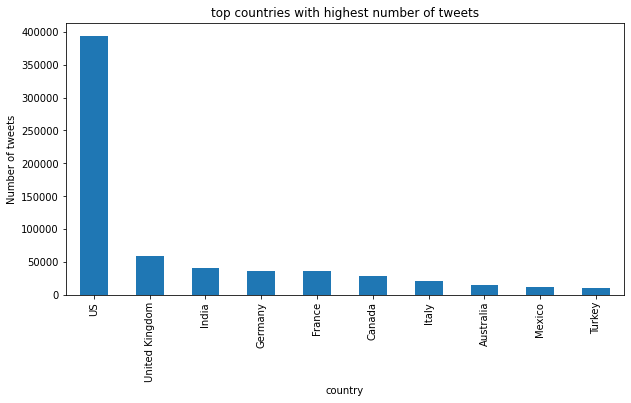

In [ ]:
# Negara dengan jumlah tweet tertinggi
plt.figure(figsize=(10,5))
data_mixed.groupby('country')['tweet'].count().sort_values(ascending=False).head(10).plot.bar()
plt.ylabel('Number of tweets')
plt.title('top countries with highest number of tweets')
plt.show()

In [ ]:
# Jumlah tweet untuk masing-masing kandidat dari tiap negara
top10countries = data_mixed.groupby('country')['tweet'].count().sort_values(ascending=False).head(10).index.tolist()
tweet_df = data_mixed.groupby(['country','Candidate'])['tweet'].count().reset_index()
tweet_df = tweet_df[tweet_df['country'].isin(top10countries)]
tweet_df

,country,Candidate,tweet
16,Australia,Trump,9365
17,Australia,biden,5534
54,Canada,Trump,16996
55,Canada,biden,10809
112,France,Trump,20689
113,France,biden,14610
118,Germany,Trump,22618
119,Germany,biden,12761
146,India,Trump,18559
147,India,biden,21532


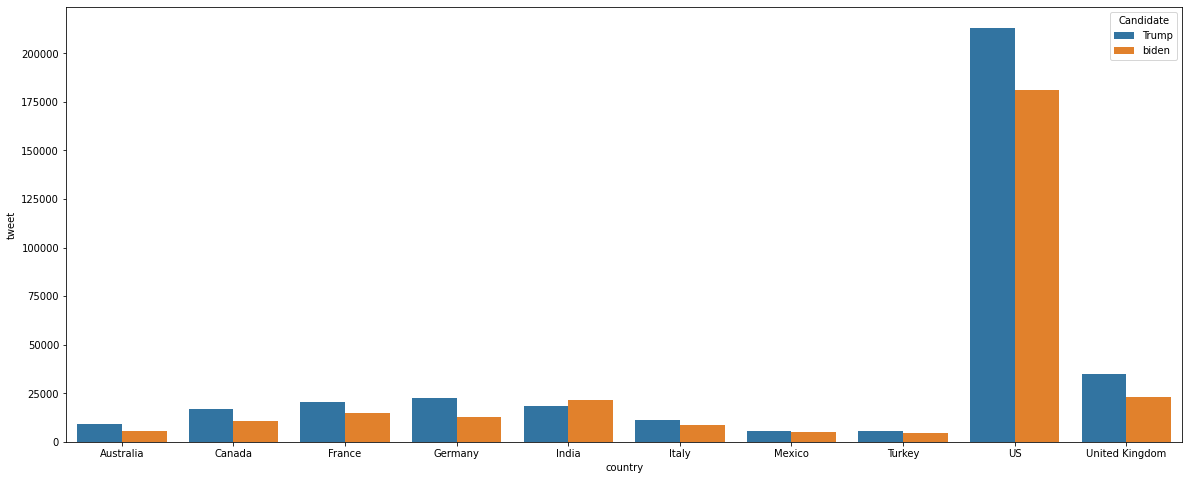

In [ ]:
# Jumlah tweet untuk masing-masing kandidat dari tiap negara
top10countries = data_mixed.groupby('country')['tweet'].count().sort_values(ascending=False).head(10).index.tolist()
tweet_df = data_mixed.groupby(['country','Candidate'])['tweet'].count().reset_index()
tweet_df = tweet_df[tweet_df['country'].isin(top10countries)]
plt.figure(figsize=(20,8))
sns.barplot(data=tweet_df,x='country',y='tweet',hue='Candidate')
plt.show()

In [ ]:
# Top 10 State jumlah tweet masing-masing kandidat
top10states = data_mixed.groupby('state')['tweet'].count().sort_values(ascending=False).head(10).index.tolist()
state_df = data_mixed.groupby(['state','Candidate'])['tweet'].count().reset_index()
state_df = state_df[state_df['state'].isin(top10states)]
state_df

,state,Candidate,tweet
206,California,Trump,31149
207,California,biden,25817
349,District of Columbia,Trump,9684
350,District of Columbia,biden,7055
386,England,Trump,24111
387,England,biden,16743
410,Florida,Trump,16568
411,Florida,biden,13284
518,Ile-de-France,Trump,9393
519,Ile-de-France,biden,7001


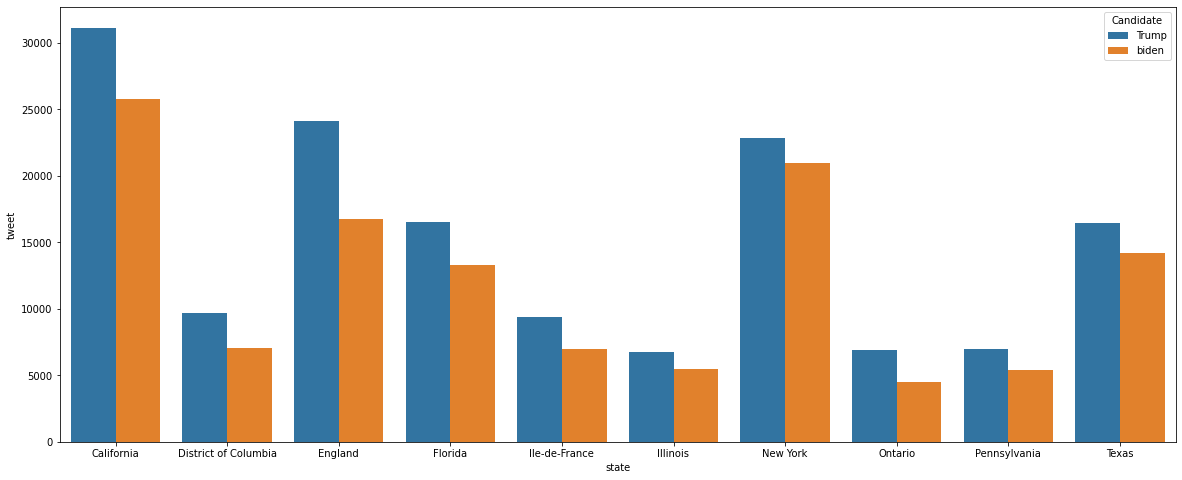

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(data=state_df,x='state',y='tweet',hue='Candidate')
plt.show()

# Persiapan Model

In [ ]:
df = data_mixed[['tweet']]
df = df[0:200000]
df.head(10)

,tweet
0,en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu
1,usa trump contro facebook twitter coprono biden
2,as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what
3,hours since last tweet from maybe he is very busy tremendously busy
4,you get tie and you get tie rally
5,her minutes were over long time ago omarosa never represented the black community she cried to begging for job
6,glad got out of the house dick
7,there wont be many of them unless you all have been voting more than once again but god prevails bo was the most corrupt president ever dark to light your lies are all coming through they wouldnt last forever
8,one of the single most effective remedies to eradicate another round of plague in our
9,


Menentukan Polaritas

In [ ]:
df['polarity'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['tweet_len'] = df['tweet'].apply(lambda x: len(x))
df['word_count'] = df['tweet'].apply(lambda x: len(x.split()))

In [ ]:
df.head()

,tweet,polarity,tweet_len,word_count
0,en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu,0.000000,104,19
1,usa trump contro facebook twitter coprono biden,0.000000,48,7
2,as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what,0.333333,226,49
3,hours since last tweet from maybe he is very busy tremendously busy,0.076667,67,12
4,you get tie and you get tie rally,0.000000,36,8


In [ ]:
def polarity_to_sentiment(x):
#     if type(x) is float:
#         for i in range(0, len(x)):
    if x > 0:
        return 2 # 2 = Positive
    if x < 0:
        return 0 # 0 = negative
    else:
        return 1 # 1 = Neutral
df['sentiments'] = df['polarity'].apply(lambda x: polarity_to_sentiment(x))
df.head()

,tweet,polarity,tweet_len,word_count,sentiments
0,en dice que solo se preocupa por mismo el demcrata fue anfitrin de encuentros de electores en clic aqu,0.000000,104,19,1
1,usa trump contro facebook twitter coprono biden,0.000000,48,7,1
2,as student used to hear for years for ten years heard china in and we have and they do not know how many we have and asked them how many do we have and they said sir we do not know but we have millions like million um what,0.333333,226,49,2
3,hours since last tweet from maybe he is very busy tremendously busy,0.076667,67,12,2
4,you get tie and you get tie rally,0.000000,36,8,1


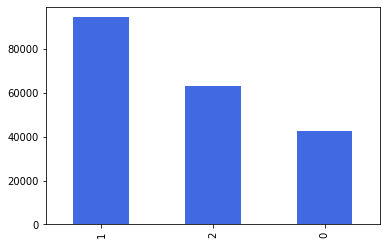

In [ ]:
df['sentiments'].value_counts().plot.bar(color='royalblue')

In [ ]:
# Splitting data
# dependent Features
y = df['sentiments']

# Independent Features
X = df.drop('sentiments', axis=1)

**Stemmer**

In [ ]:
messages = X.copy()

In [ ]:
from nltk import PorterStemmer
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['tweet'][i])
    review = review.lower()
    review = review.split()
    review = [w for w in nltk.wordpunct_tokenize(str(review)) if w.lower() in words or not w.isalpha()]
    
    review = [ps.stem(word) for word in review if not word in stopwords]
    review = ' '.join(review)
    corpus.append(review)
corpus[0]

"[' en ', ' dice ', ' ', ' solo ', ' se ', ' ', ' ', ' ', ' el ', ' ', ' ', ' ', ' de ', ' ', ' de ', ' ', ' en ', ' ', ' ']"

Tokenize Data

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
voc_size = 50000
max_len = 120
embedding_features = 32
tokenizer = Tokenizer(num_words=voc_size, oov_token = '<OOV>')
tokenizer.fit_on_texts(corpus)

Embedding

In [ ]:
sequences = tokenizer.texts_to_sequences(corpus)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
embedded_doc = pad_sequences(sequences, maxlen=max_len, padding= 'post', truncating = 'post')
embedded_doc[0]

array([  2,  16,   2,   2, 685,   2,   2,   2,   2, 791,   2,   2,  89,
         2,   2,   2,   2,   2,   2,   2,   2,  25,   2,   2,   2,   2,
         2,   2,   2,   2,   4,   2,   2,   2,   2,   4,   2,   2,   2,
         2,  16,   2,   2,   2,   2,   2,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0], dtype=int32)

In [ ]:
X_final = np.array(embedded_doc)
y_final = np.array(y)
X_final.shape, y_final.shape

((200000, 120), (200000,))

# Pembuatan Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU

In [ ]:
model = Sequential()
model.add(Embedding(voc_size, embedding_features, input_length = max_len))
# model.add(Dropout(0.3))
model.add(GRU(100))
model.add(Dense(32, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(16, activation = 'relu'))
# model.add(Dropout(0.3))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 32)           1600000   
                                                                 
 gru_1 (GRU)                 (None, 100)               40200     
                                                                 
 dense_3 (Dense)             (None, 32)                3232      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 3)                 51        
                                                                 
Total params: 1,644,011
Trainable params: 1,644,011
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.25, stratify = y, random_state=42)

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 8, batch_size=64)

Epoch 1/8
2344/2344 [==============================] - 360s 153ms/step - loss: 0.5843 - accuracy: 0.7662 - val_loss: 0.4720 - val_accuracy: 0.8353
Epoch 2/8
2344/2344 [==============================] - 352s 150ms/step - loss: 0.4159 - accuracy: 0.8567 - val_loss: 0.4071 - val_accuracy: 0.8625
Epoch 3/8
2344/2344 [==============================] - 352s 150ms/step - loss: 0.3808 - accuracy: 0.8718 - val_loss: 0.3942 - val_accuracy: 0.8703
Epoch 4/8
2344/2344 [==============================] - 346s 148ms/step - loss: 0.3622 - accuracy: 0.8771 - val_loss: 0.3876 - val_accuracy: 0.8717
Epoch 5/8
2344/2344 [==============================] - 350s 149ms/step - loss: 0.3479 - accuracy: 0.8806 - val_loss: 0.3925 - val_accuracy: 0.8710
Epoch 6/8
2344/2344 [==============================] - 351s 150ms/step - loss: 0.3312 - accuracy: 0.8845 - val_loss: 0.3851 - val_accuracy: 0.8736
Epoch 7/8
2344/2344 [==============================] - 351s 150ms/step - loss: 0.3115 - accuracy: 0.8908 - val_loss: 0


# Evaluasi

In [ ]:
y_pred = ((model.predict(X_test)>0.5).astype('int32'))

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, np.argmax(y_pred, axis = 1))

array([[ 8542,   832,  1242],
       [ 1058, 21979,   566],
       [ 1462,  1470, 12849]])

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, np.argmax(y_pred, axis=1))

0.8674

# Analisis Sentimen tiap Kandidat

In [ ]:
def getsubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getpolarity(text):
    return TextBlob(text).sentiment.polarity
def getAnalysis(score):
    if score <0:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:
        return 'positive'

Trump

In [ ]:
trump_tweets = data_mixed.query('(Candidate == "Trump")').sort_values('user_followers_count',ascending=False).drop_duplicates(['user_name'])[['tweet','country']]
trump_tweets = trump_tweets.dropna().loc[trump_tweets.country =='US']
trump_tweets.reset_index(inplace = True ,drop =True)
trump_tweets

,tweet,country
0,without doubt the debacle is the best part of electionlosing meltdown are these guys serious,US
1,president donald youngest daughter tiffany spoke at trump pride rally in tampa florida over the weekend and shared her views on her fathers credibility with the community,US
2,woah have you read this article all the presidents debts to whom donald trump owes money,US
3,the latest episode of tackled loss in the cold open starring maya rudolph alec baldwin and jim carrey,US
4,firmar una serie de rdenes ejecutivas en cuanto tome el cargo para revertir acciones de va,US
...,...,...
45518,you wanted it over by election nights candidates are never certified on election nights they will be soon your reign of terror and stupidity is over never mind election lawyers you need criminal lawyers,US
45519,even if did win this election he would still call it rigged it never ends with him fraud,US
45520,twisted pressed amp curled almost empty toothpaste tube for straight days amp everytime it seemed impossible but on the th day being zero hope inflated that tube amp poured water so as to put atleast something on teeth amp yes it was success unlike,US
45521,since trump is losing watch the other side of him,US


In [ ]:
trump_tweets['subjectivity'] = trump_tweets['tweet'].apply(getsubjectivity)
trump_tweets['polarity'] = trump_tweets['tweet'].apply(getpolarity)
trump_tweets['analysis'] = trump_tweets['polarity'].apply(getAnalysis)
trump_tweets.head()

,tweet,country,cleantext,subjectivity,polarity,analysis
0,without doubt the debacle is the best part of electionlosing meltdown are these guys serious,US,without doubt the debacle is the best part of electionlosing meltdown are these guys serious,0.483333,0.333333,positive
1,president donald youngest daughter tiffany spoke at trump pride rally in tampa florida over the weekend and shared her views on her fathers credibility with the community,US,president donald youngest daughter tiffany spoke at trump pride rally in tampa florida over the weekend and shared her views on her fathers credibility with the community,0.000000,0.000000,neutral
2,woah have you read this article all the presidents debts to whom donald trump owes money,US,woah have you read this article all the presidents debts to whom donald trump owes money,0.000000,0.000000,neutral
3,the latest episode of tackled loss in the cold open starring maya rudolph alec baldwin and jim carrey,US,the latest episode of tackled loss in the cold open starring maya rudolph alec baldwin and jim carrey,0.800000,-0.033333,negative
4,firmar una serie de rdenes ejecutivas en cuanto tome el cargo para revertir acciones de va,US,firmar una serie de rdenes ejecutivas en cuanto tome el cargo para revertir acciones de va,0.000000,0.000000,neutral


In [ ]:
trump_tweets.analysis.value_counts(normalize=True)*100

neutral     45.032182
positive    35.368934
negative    19.598884
Name: analysis, dtype: float64

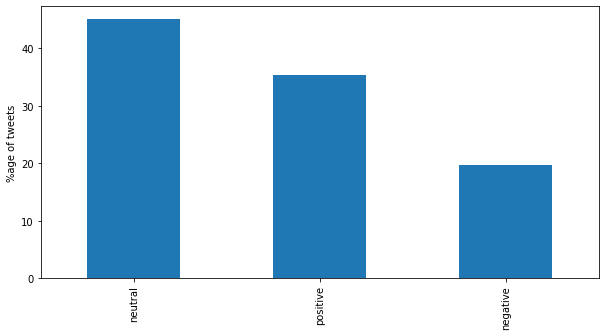

In [ ]:
# Persebaran Sentimen Trump
plt.figure(figsize=(10,5))
(trump_tweets.analysis.value_counts(normalize=True)*100).plot.bar()
plt.ylabel("%age of tweets")
plt.show()

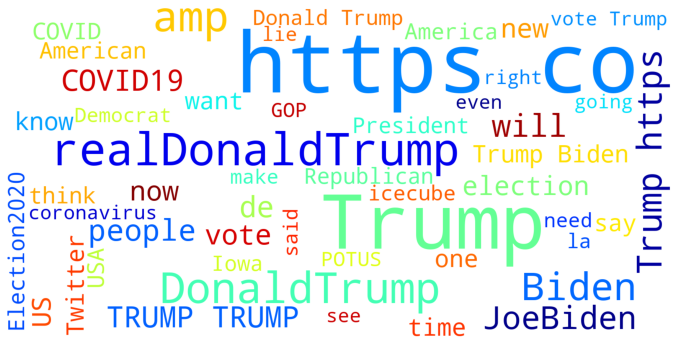

In [ ]:
from wordcloud import WordCloud, STOPWORDS
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(background_color='white',
                         stopwords= stopwords,
                         width = 1600,height=800,
                         random_state=1,
                         colormap='jet',
                         max_words=50,
                         max_font_size=200).generate(all_words)
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(wordcloud)
word_cloud(trump['tweet'][:5000])

Biden

In [ ]:
biden_tweets = data_mixed.query('(Candidate=="biden")').sort_values('user_followers_count',ascending =False).drop_duplicates(['user_name'])[['tweet','country']]
biden_tweets = biden_tweets.dropna().loc[biden_tweets.country=='US']
biden_tweets.reset_index(inplace=True,drop=True)
biden_tweets

,tweet,country
0,is enlisting alist star power to help close out campaign season do yall think this appearance move the needle,US
1,while we were campaigning across battleground states we ran into great folks like this brother,US
2,the big fight today vs who you got,US
3,news outlets have projected that has secured electoral votes with victory in and will become the th president of the united states,US
4,during his victory speech said he understood that trump supporters were disappointed but this is the time to heal,US
...,...,...
57545,th president of the unites states congratulations joe biden and kamala harris,US
57546,biden is going to win tonight,US
57547,all deaths recorded in the united states from the covid alone of coz usa need more than ever for it nation to recover from blood usa needs more new people folks blue black white do not care it all human,US
57548,joe bidenin baa gelmesi bizim bence iimize gelir nk yalan yok trump zeki adam bi gn gelip iimizden geebilir dolar ohomm oylar biden reise,US


In [ ]:
biden_tweets['subjectivity'] = biden_tweets['tweet'].apply(getsubjectivity)
biden_tweets['polarity'] = biden_tweets['tweet'].apply(getpolarity)
biden_tweets['analysis'] = biden_tweets['polarity'].apply(getAnalysis)
biden_tweets.head()

,tweet,country,subjectivity,polarity,analysis
0,is enlisting alist star power to help close out campaign season do yall think this appearance move the needle,US,0.00,0.00,neutral
1,while we were campaigning across battleground states we ran into great folks like this brother,US,0.75,0.80,positive
2,the big fight today vs who you got,US,0.10,0.00,neutral
3,news outlets have projected that has secured electoral votes with victory in and will become the th president of the united states,US,0.00,0.00,neutral
4,during his victory speech said he understood that trump supporters were disappointed but this is the time to heal,US,0.75,-0.75,negative


In [ ]:
biden_tweets.analysis.value_counts(normalize=True)*100

neutral     46.653345
positive    38.773241
negative    14.573414
Name: analysis, dtype: float64

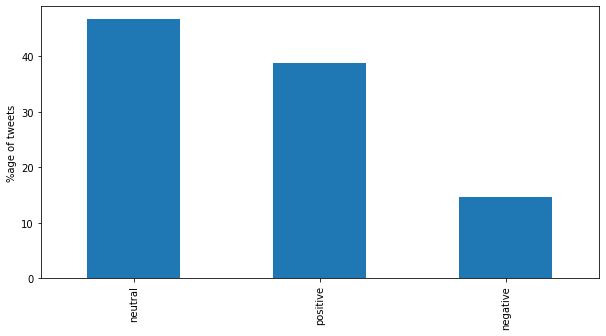

In [ ]:
plt.figure(figsize=(10,5))
(biden_tweets.analysis.value_counts(normalize=True)*100).plot.bar()
plt.ylabel("%age of tweets")
plt.show()

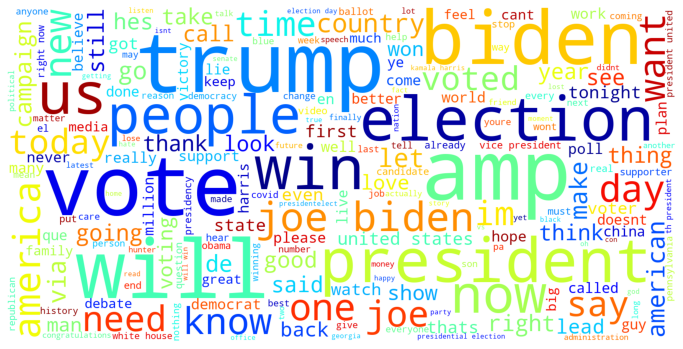

In [ ]:
from wordcloud import WordCloud, STOPWORDS
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(background_color='white',
                         stopwords= stopwords,
                         width = 1600,height=800,
                         random_state=1,
                         colormap='jet',
                         max_words=200,
                         max_font_size=200).generate(all_words)
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(wordcloud)
word_cloud(biden_tweets['tweet'][:5000])